In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import openpyxl
from gensim.models import CoherenceModel
import tqdm

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(il_ilce)

In [4]:
df = pd.read_excel("Policy_Actions.xlsx")

In [5]:
df.columns

Index(['City \n(*innovator)', 'Land-use Policy/Planning '], dtype='object')

In [6]:
data= df["Policy_A"]

In [7]:
# Remove punctuation
data.map(lambda x: re.sub('[,\.!?;/]', '', x))
# Convert the titles to lowercase
data = \
data.map(lambda x: x.lower())
# Print out the first rows of papers
data.head()
data = data.values.tolist()

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['energy', 'promotion', 'of', 'clean', 'and', 'renewable_energy', 'initative', 'funding', 'awareness', 'campaigns', 'encourage', 'renewable_energy', 'in', 'public', 'residential', 'buildings', 'and', 'social', 'sites', 'schools', 'hospitals', 'etc', 'mobility', 'support', 'the', 'creation', 'of', 'pedestrian', 'and', 'cycleable', 'infrastructure', 'establishment', 'of', 'pedestrian', 'zones', 'study', 'the', 'establishment', 'of', 'low', 'emission_zone', 'support', 'the', 'development', 'of', 'multimodal', 'transport', 'systems', 'green_spaces', 'target', 'plant', 'trees', 'green', 'plan', 'project', 'agriculture', 'promote', 'the', 'development', 'of', 'urban', 'and', 'peri', 'urban', 'agriculture']


In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
spacy.load('en_core_web_sm')

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['energy', 'promotion', 'clean', 'renewable_energy', 'initative', 'funding', 'awareness', 'campaign', 'encourage', 'renewable_energy', 'public', 'residential', 'building', 'social', 'site', 'school', 'hospital', 'mobility', 'support', 'creation', 'pedestrian', 'cycleable', 'infrastructure', 'establishment', 'pedestrian', 'zone', 'study', 'establishment', 'low', 'support', 'development', 'multimodal', 'transport', 'system', 'space', 'target', 'plant', 'tree', 'green', 'plan', 'project', 'agriculture', 'promote', 'development', 'urban', 'agriculture']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=10,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"energy" + 0.022*"upgrade" + 0.021*"walk" + 0.021*"corridor" + '
  '0.018*"mobility" + 0.017*"target" + 0.015*"solar" + 0.015*"city" + '
  '0.014*"roof" + 0.014*"infrastructure"'),
 (1,
  '0.030*"action" + 0.030*"target" + 0.023*"mobility" + 0.023*"agriculture" + '
  '0.023*"green" + 0.023*"space" + 0.023*"cycle_path" + 0.023*"km" + '
  '0.015*"encourage" + 0.015*"waste"'),
 (2,
  '0.023*"target" + 0.022*"bicycle" + 0.022*"promote" + 0.022*"increase" + '
  '0.022*"green" + 0.022*"waste" + 0.022*"urban" + 0.015*"energy" + '
  '0.015*"lane" + 0.015*"community"'),
 (3,
  '0.045*"target" + 0.022*"bike" + 0.021*"expand" + 0.020*"solar" + '
  '0.019*"green" + 0.016*"own" + 0.016*"community" + 0.016*"installation" + '
  '0.016*"space" + 0.015*"park"'),
 (4,
  '0.038*"policy" + 0.020*"action" + 0.020*"bicycle" + 0.020*"develop" + '
  '0.020*"include" + 0.020*"example" + 0.020*"use" + 0.020*"land" + '
  '0.020*"strict" + 0.020*"electrify"'),
 (5,
  '0.039*"target" + 0.034*"green" 

In [16]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.493113695830584

Coherence Score:  0.4502370778194325


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=750,chunksize=100,passes=10,)

        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                            passes=10,
                                           alpha=0.91,
                                           eta='symmetric',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=12, limit=40, step=2)

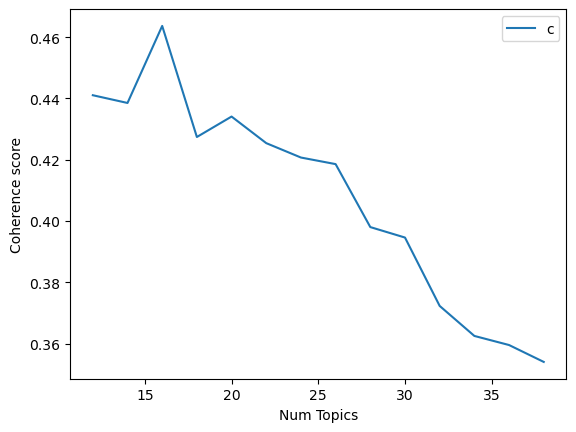

In [19]:
import matplotlib.pyplot as plt
limit=40; start=12; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [20]:
coherence_values

[0.4410444029152074,
 0.4385167299803336,
 0.46366169317045197,
 0.427412910312005,
 0.4340831300218001,
 0.42540800793370986,
 0.4207099101136555,
 0.4185619945670172,
 0.3980144196867446,
 0.3945971420848596,
 0.372282406254294,
 0.3624909272526098,
 0.3595226471804019,
 0.35400953451145184]

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

In [22]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(21,
  '0.001*"ultra" + 0.001*"vagueness" + 0.001*"district" + 0.001*"gw" + '
  '0.001*"indicative" + 0.001*"key" + 0.001*"meet" + 0.001*"message" + '
  '0.001*"mode" + 0.001*"present"'),
 (6,
  '0.001*"green" + 0.001*"bicycle" + 0.001*"urban" + 0.001*"sub" + '
  '0.001*"network" + 0.001*"action" + 0.001*"infrastructure" + 0.001*"repair" '
  '+ 0.001*"cycle_path" + 0.001*"participatory"'),
 (7,
  '0.002*"maintain" + 0.002*"mile" + 0.002*"acre" + 0.002*"target" + '
  '0.002*"expand" + 0.001*"bicycle" + 0.001*"additional" + 0.001*"program" + '
  '0.001*"protect" + 0.001*"green"'),
 (19,
  '0.001*"action" + 0.001*"infrastructure" + 0.001*"cycling" + 0.001*"base" + '
  '0.001*"urban" + 0.001*"walk" + 0.001*"agriculture" + 0.001*"pedestrian" + '
  '0.001*"strengthen" + 0.001*"implement"'),
 (1,
  '0.002*"action" + 0.002*"agriculture" + 0.002*"zone" + 0.002*"energy" + '
  '0.002*"land" + 0.002*"green" + 0.002*"encourage" + 0.001*"target" + '
  '0.001*"mobility" + 0.001*"new"'),
 (18,
  '0.0

In [23]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [24]:
#to be able to choose the best model

import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 11
max_topics = 35
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               #corpus]
#corpus_title = ['75% Corpus', '100% Corpus'], 'Validation_Set': [],
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    #for i in range(len(corpus_sets)):
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                                k=k, a=a, b=b)
                # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)


                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_national.csv', index=False)
    pbar.close()

 24%|█████████▋                               | 128/540 [03:43<12:40,  1.85s/it]
KeyboardInterrupt



In [87]:
#results of tuning part
df3= pd.read_csv("Policy Actions.csv")

In [88]:
df3.sort_values(by=["Coherence"],ascending=False).head(20)

Topics               Alpha                Beta  Coherence
132      19                0.61                0.61   0.597495
47       13  0.9099999999999999                0.61   0.594818
133      19                0.61  0.9099999999999999   0.569549
102      17                0.61                0.61   0.569434
238      25          asymmetric  0.9099999999999999   0.566965
163      21                0.61  0.9099999999999999   0.566261
106      17  0.9099999999999999                0.31   0.565849
293      29           symmetric  0.9099999999999999   0.561296
273      29                0.01  0.9099999999999999   0.559416
222      25                0.61                0.61   0.557400
251      27                0.61                0.31   0.554671
239      25          asymmetric           symmetric   0.553917
297      29          asymmetric                0.61   0.552172
298      29          asymmetric  0.9099999999999999   0.552019
237      25          asymmetric                0.61   0.549306
270      29                0.01                0.01   0.548608
354      33           symmetric           symmetric   0.547955
103      17                0.61  0.9099999999999999   0.547872
350      33           symmetric                0.01   0.547712
252      27                0.61                0.61   0.547538

In [89]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=19, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta="auto",
                                           per_word_topics=True)

In [90]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2725234472633735

Coherence Score:  0.48575701117419945


In [91]:
ldamodel = lda_model
texts=data

In [92]:
sent_topics_df = pd.DataFrame()
sent_topics_df_list = list()

In [93]:
for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df_list.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]))
            else:
                break

In [94]:
sent_topics_df_list[0]

0                                                    2
1                                               0.1865
2    vulnerable, community, climate, area, prone, u...
dtype: object

In [95]:
sent_topics_df = pd.concat(sent_topics_df_list,axis=1,ignore_index=True)

In [96]:
sent_topics_df = sent_topics_df.transpose()

In [97]:
sent_topics_df

0       1                                                  2
0    2  0.1865  vulnerable, community, climate, area, prone, u...
1   16  0.2103  energy, household, poverty, solar, low_income,...
2   14  0.3579  expansion, vulnerable, access, target, poor, c...
3   16  0.7036  energy, household, poverty, solar, low_income,...
4   16  0.3092  energy, household, poverty, solar, low_income,...
..  ..     ...                                                ...
61   5  0.2801  vulnerable, community, solar, implement, infor...
62  10  0.1872  energy, space, access, green, low_income, hous...
63   1  0.2749  access, woman, community, sharing, prioritize,...
64  13  0.2242  protect, conservation, promote, gender, city, ...
65   1  0.2188  access, woman, community, sharing, prioritize,...

[66 rows x 3 columns]

In [98]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    sent_topics_df_list = list()
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df_list.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]))
            else:
                break
    sent_topics_df = pd.concat(sent_topics_df_list,axis=1,ignore_index=True)
    sent_topics_df = sent_topics_df.transpose()
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No Dominant_Topic Topic_Perc_Contrib  \
0            0              2             0.1865   
1            1             16             0.2103   
2            2             14             0.3578   
3            3             16             0.7036   
4            4             16             0.3092   
5            5              6             0.3008   
6            6              1             0.7644   
7            7              0             0.4193   
8            8              8             0.1329   
9            9              2             0.3054   

                                            Keywords  \
0  vulnerable, community, climate, area, prone, u...   
1  energy, household, poverty, solar, low_income,...   
2  expansion, vulnerable, access, target, poor, c...   
3  energy, household, poverty, solar, low_income,...   
4  energy, household, poverty, solar, low_income,...   
5  public, area, impact, low_income, certain, tra...   
6  access, woman, community, sharing, prioritize,...   
7  vulnerable, especially, health, social, housin...   
8  benefit, mobility, transport, income, carbon, ...   
9  vulnerable, community, climate, area, prone, u...   

                                                Text  
0   empower women and young people through the de...  
1  coastal management benefit. livelihood diversi...  
2   greater equality of opportunity, access to ed...  
3  solar. the climate justice chapter states that...  
4  green pocket small parks expansion will facili...  
5  mobility: adjust public transport prices to su...  
6  first strategy under sustainable buildings inc...  
7  green infrastructure access to all urban popul...  
8  the expension of cycle paths and public transp...  
9  regional strategy for the attention of migrant...

In [99]:
# the topic numbers are not compatible with the topic numbers in plydavis graph. So, I made the chages below
#a=[1,5,3,10,7,7,1,6,7,8,1,4,2,11,2,9,2,12,1,3,3,4,3,5,8,2,4,14,13,1,1,1,1,5,5,2,3]
#df_topic_sents_keywords["Dominant_Topic"]= a
df_dominant_topic["Document Title"] = df["Distributive Justice"]
df_dominant_topic.to_csv('national_dominant_topics_fin_Bottom.csv')  
#df_dominant_topic["Dominant_Topic"] = a

In [190]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)
#sent_topics_sorteddf_mallet.to_csv('local_textsum_topics_and_representatives.csv')  

Topic_Num  Topic_Perc_Contrib  \
0          0              0.8610   
1          1              0.9060   
2          3              0.7727   
3          4              0.8658   
4          5              0.9048   
5          6              0.8752   
6          8              0.9169   
7          9              0.9168   
8         10              0.8602   
9         13              0.4235   

                                                                                              Keywords  \
0       study, desertification, climate, country, risk, publication, natural, program, action, drought   
1                        energy, city, environment, increase, resource, life, use, waste, target, year   
2                    main, fulfill, protection, good, national, service, work, park, strategic, forest   
3       national, city, strategy, drought, take, policy, sustainable, include, development, management   
4  system, settlement, planning, environmental, management, plan, ensure, pollution, principle, bui...   
5  development, natural_resource, program, soil, country, deplete, decrease, live, environmental, c...   
6  effort, global, national, development, international, common, principle, capacity, adaptation, m...   
7             energy, country, supply, resource, production, market, reduce, increase, plan, strategic   
8  climate_change, adaptation, strategy, impact, water_resource, national, term, forest, ecosystem,...   
9  waste, waste_management, prepare, current_situation, municipality, investment, recovery, collect...   

                                                                                   Representative Text  
0  [observation, forecasting, study, show, geographical, difference, frequency, impact, level, seve...  
1  [ministry, environment, urbanization, new, era, continue, service, activity, field, nature, envi...  
2  [decree, law, date, organization, duty, work, establish, determine, national, international, pol...  
3  [smart, city, strategy, first, world, fourth, smart, city, strategy, prepare, national, level, s...  
4  [strategic, plan, underline, way, create, brand, city, create, environmentally, friendly, city, ...  
5  [live, healthy, environment, primary, human, right, climate, change, due, global_warming, drough...  
6  [primary, objective, scope, global, combat, climate_change, participate, global, effort, carry, ...  
7  [prepare, strategic, plan, cover, year, perspective, country, policy, energy, strategic, plan, p...  
8  [accord, scientific, evidence, nature, conservation, experience, protected_area, essential, part...  
9  [document, prepare, line, implementation, national, legislation, scope, plan, aim, analyze, curr...

In [ ]:
#You can find the topics represented in Plydavis graph and the keywords here

topics = lda_model.show_topics(num_topics=19)
topics[0][0] =3
topics[1][0] = 1
topics[2][0]=19
topics[3][0] =12
topics[4][0] =5
topics[5][0] =8
topics[6][0] =10
topics[7][0] =15
topics[8][0] = 9
topics[9][0] =6
topics[10][0] =2
topics[11][0] = 17
topics[12][0]=16
topics[13][0] =13
topics[14][0] =18
topics[15][0] =11
topics[16][0] =4
topics[17][0] =14
topics[18][0] = 7

topics


In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

my_stop_words = STOPWORDS.union(set(il_ilce))
#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=my_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=12,
                  colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#topics = lda_model.show_topics(num_topics=22,formatted=False)

fig, axes = plt.subplots(4, 3, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(topics[i][0]), fontdict=dict(size=16))
    plt.gca().axis('off')
    isim='national_wordcloud'+ str(topics[i][0])+".png"
    cloud.to_file(isim)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
LDAvis_prepared

In [19]:
pyldavis_dict2 = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=True, mds='mmds').to_dict()


c:\ProgramData\Miniconda3\envs\myenv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [20]:
df_token = pd.DataFrame.from_dict(pyldavis_dict2['token.table'])
df_term = pd.DataFrame.from_dict(pyldavis_dict2['tinfo'])
df_topic = pd.DataFrame.from_dict(pyldavis_dict2['mdsDat'])

In [21]:
dict_df_term2 = {}
topic_num=20
for i in range(1,topic_num):
    find = "Topic"+str(i)
    df_term2 = df_term[df_term['Category'] == find ].sort_values(by=['Freq'],ascending=False)
    dict_df_term2[find] = df_term2["Term"].to_list()